In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax.random import PRNGKey, split
import hyperiax
import jax
from jax import numpy as jnp
from hyperiax.execution import LevelwiseTreeExecutor
from hyperiax.models import DownLambda, UpDownLambda
from hyperiax.models.functional import sum_fuse_children
from hyperiax.tree.updaters import update_noise_inplace
from hyperiax.mcmc import ParameterStore, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots

from tqdm.auto import tqdm


In [3]:
import matplotlib.pyplot as plt 

# plotting
def plot_shape(q):
    q = q.reshape((-1,d))
    plt.plot(q[:,0],q[:,1],'.')
    plt.axis('equal')

In [4]:
key = PRNGKey(0)

# Gaussian tree, constant node covariance

In [5]:
# diffusion and covariance specification for shape processes
kQ12 = lambda x,theta: theta['k_alpha']*jnp.exp(-.5/theta['k_sigma']*jnp.sum(jnp.square(x),2))

# evaluate k on two pairs of landmark configurations
kQ12_q = lambda q1,q2,theta: kQ12(q1.reshape((-1,d))[:,jnp.newaxis,:]-q2.reshape((-1,d))[jnp.newaxis,:,:],theta)

# evaluate k on one landmark configurations against itself with each landmark pair resulting in a dxd matric
# i,jth entry of result is kQ12(x_i,x_j)*eye(d)
def Q12(q,theta): 
    A = jnp.einsum('ij,kl->ikjl',kQ12_q(q,q,theta),jnp.eye(2))
    return A.reshape((A.shape[0]*A.shape[1],A.shape[2]*A.shape[3]))

def Q(q,theta):
    return jnp.einsum('ij,kj->ik',Q12qtheta,Q12qtheta)

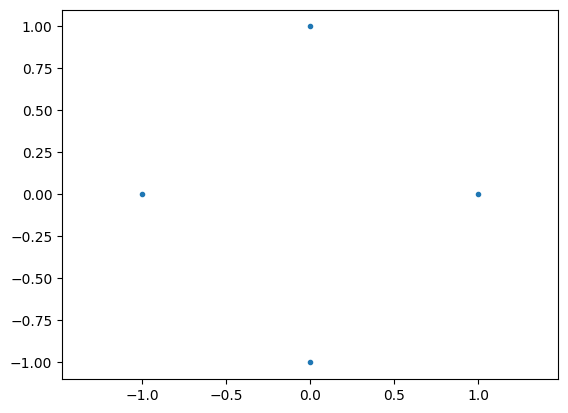

In [6]:
d = 2; n = 4 # d = dimension of embedding space (usually 2), n = number of landmarkds
phis = jnp.linspace(0,2*jnp.pi,n,endpoint=False) # circular shape
q = jnp.vstack((jnp.cos(phis),jnp.sin(phis))).T.flatten()

# plot
plot_shape(q)

In [7]:
# parameters, diffusion matrix and covariance
params = ParameterStore({
    'k_alpha': VarianceParameter(.5), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(1.), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-2) # obersevation noise variance
    })

sigma = lambda params: Q12(q,params)
def a(params): _sigma = sigma(params); return jnp.einsum('ij,kj->ik',_sigma,_sigma)

In [8]:
# batched version of down_unconditional. The b index refers to the batch, the first axis of W
def down_unconditional(noise,edge_length,parent_value,params,**args):
    T,W = edge_length,noise # edge length and noise
    var = T[:, jnp.newaxis] # total edge variance
    S = sigma(params)

    return {'value': parent_value+jnp.sqrt(var)*jnp.einsum('ij,bj->bi',S,W)}
# vmapped version of down_unconditional. In this version, the function takes a single node, not a batch
@jax.jit
def down_unconditional(noise,edge_length,parent_value,params,**args):
    def f(noise,edge_length,parent_value):
        T,W = edge_length,noise # edge length and noise
        var = T # total edge variance
        S = sigma(params)

        return {'value': parent_value+jnp.sqrt(var)*jnp.einsum('ij,j->i',S,W)}

    return jax.vmap(f)(noise,edge_length,parent_value)

@jax.jit
def down_conditional(noise,edge_length,parent_F_T,parent_H_T,parent_value,params,**args):
    def f(noise,edge_length,F_T,H_T,parent_value):
        T,W = edge_length,noise # edge length and noise
        x = parent_value
        var = T # total edge variance

        invSigma = jnp.linalg.inv(var*a(params))
        H = H_T+invSigma
        mu = jnp.linalg.solve(H,F_T+invSigma@x)
        return {'value': mu+jnp.linalg.solve(jax.scipy.linalg.sqrtm(H),W)}

    return jax.vmap(f)(noise,edge_length,parent_F_T,parent_H_T,parent_value)
@jax.jit
def up(noise,edge_length,F_T,H_T,params,**args):
    def f(noise,edge_length,F_T,H_T):
        T,W = edge_length,noise
        var = T # total edge variance

        Sigma_T = jnp.linalg.inv(H_T)
        v_T = Sigma_T@F_T
    
        invPhi_0 = (jnp.eye(n*d)+H_T*a(params)*var)
        Sigma_0 = Sigma_T@invPhi_0 # = Sigma_T+a(theta)*T
        H_0 = jnp.linalg.inv(Sigma_0)
        F_0 = jnp.linalg.solve(invPhi_0,F_T)
        v_0 = Sigma_0@F_0
        c_0 = -jax.scipy.stats.multivariate_normal.logpdf(v_0,jnp.zeros(n*d),Sigma_0)
    
        return {'c_0': c_0, 'F_0': F_0, 'H_0': H_0, 'F_T': F_T, 'H_T': H_T}
    return jax.vmap(f)(noise,edge_length,F_T,H_T)

# create executors, uncoditional and conditional down passes
downmodel_unconditional = DownLambda(down_fn=down_unconditional)
updownmodel = UpDownLambda(up_fn=up,fuse_fn=sum_fuse_children(axis=0),down_fn=down_conditional)
down_unconditional = LevelwiseTreeExecutor(downmodel_unconditional)
updown = LevelwiseTreeExecutor(updownmodel)

In [9]:
# create tree and initialize with noise
root = hyperiax.tree.TreeNode()
tree = hyperiax.tree.builders.THeight_legacy(2,100,fake_root=root)
#tree = jaxtrees.tree.builders.THeight_legacy(10,2,fake_root=root)
subkey, key = split(key)

# set edge lengths on all nodes
edge_length = 1.
tree['edge_length'] = edge_length

tree.root['value'] = q

noise_tree = hyperiax.tree.initializers.initialize_noise(tree, subkey, (n*d,))
dtree = down_unconditional.down(noise_tree,params.values())
leaf_tree = dtree.copy()
# initialize tree for up
for node in leaf_tree.iter_bfs():
    key, subkey = split(key)
    if node.children:
        del node['value']
    else:
        node['value'] += jnp.sqrt(params['obs_var'].value)*jax.random.normal(subkey,node['value'].shape) # add observation noise
        v = node['value']
        Sigma = params['obs_var'].value*jnp.eye(n*d)
        H = jnp.eye(n*d)/params['obs_var'].value
        F = H@v
        c = -jax.scipy.stats.multivariate_normal.logpdf(v,jnp.zeros(n*d),Sigma)
        node.data = {**node.data, 'F_T': F, 'H_T': H}
utree = updown.up(leaf_tree,params.values())
utree.root['value'] = q
dtree_conditional = updown.down(utree,params.values())

In [10]:
# tests

# test Gaussian approximation against leaf data
leaves = jnp.array([n['value'] for n in dtree.iter_leaves()])
c = utree.root['c_0']; F = utree.root['F_0']; H = utree.root['H_0']
print("root conditional mean vs. sample mean:",jnp.linalg.solve(H,F),jnp.mean(leaves,0))
print("root conditional cov vs. sample cov:",jnp.linalg.inv(H),jnp.cov(leaves.T))

# sample statistics
K = 500 # number samples
level = 1
samples = jnp.zeros((K,len(list(dtree.iter_leaves())),d*n))

# sample new noise
update_noise = lambda tree,key: update_noise_inplace(lambda node,new: new,tree,key)

for i in tqdm(range(K)):
    subkey, key = split(key)
    update_noise(noise_tree,subkey)
    dtree = down_unconditional.down(noise_tree,params.values())
    samples.at[i].set(jnp.array([n.data['value'] for n in dtree.iter_leaves()]))
    if level == len(list(noise_tree.iter_levels()))-1:
        key,subkey = jax.random.split(key)
        samples[i] += jnp.sqrt(params['obs_var'].value)*jax.random.normal(subkey,samples[i].shape) # add observation noise
print("leaves: ")
for i in range(samples.shape[1]):
    #for j in range(K): plot_shape(samples[j,i])
    #plt.show()
    print("mean: ",jnp.mean(samples[:,i],0))
    print("cov: ",jnp.cov(samples[:,i].T))

root conditional mean vs. sample mean: [ 0.08655157 -0.4679054  -0.27971673  0.20939544 -0.8876465  -0.02206978
  0.03294384 -1.3674215 ] [ 0.08157305 -0.47443473 -0.2789782   0.2028441  -0.8885133  -0.0126829
  0.02499137 -1.3524657 ]
root conditional cov vs. sample cov: [[0.32234657 0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.32234657 0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.32234654 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.32234654 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.32234654 0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.32234654
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.32234654 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.32234654]] [[ 0.285315   -0.00138688  0.16826998 

  0%|          | 0/500 [00:00<?, ?it/s]

leaves: 
mean:  [0. 0. 0. 0. 0. 0. 0. 0.]
cov:  [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
mean:  [0. 0. 0. 0. 0. 0. 0. 0.]
cov:  [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
mean:  [0. 0. 0. 0. 0. 0. 0. 0.]
cov:  [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
mean:  [0. 0. 0. 0. 0. 0. 0. 0.]
cov:  [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.

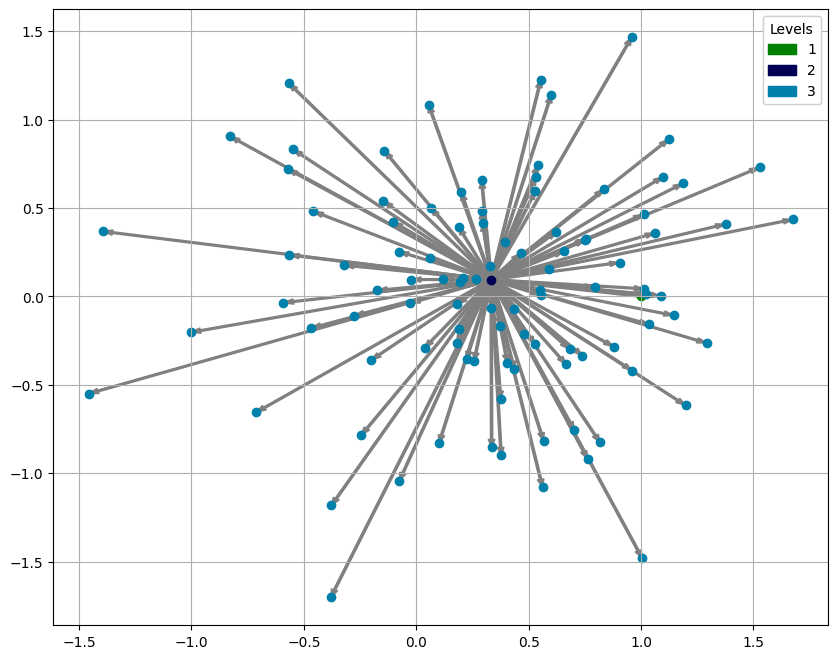

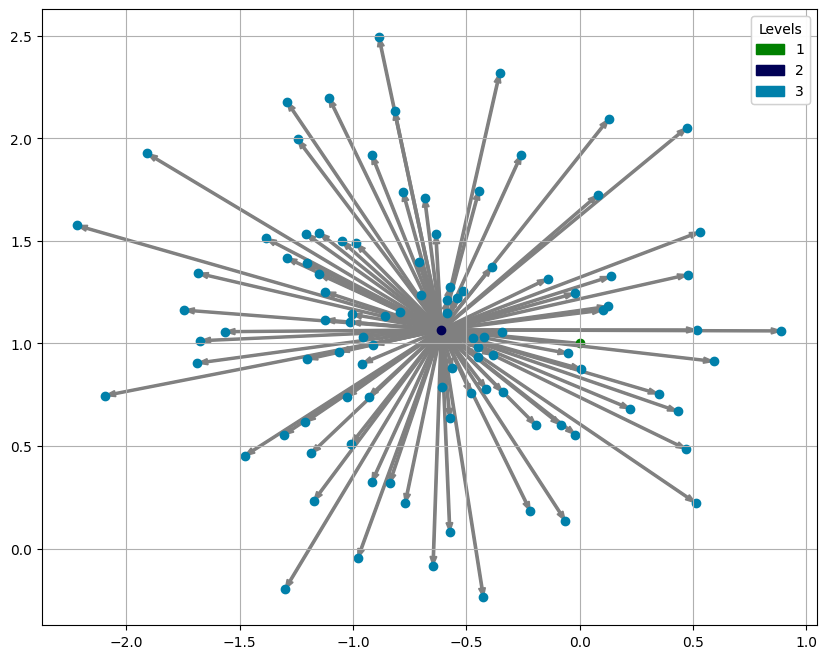

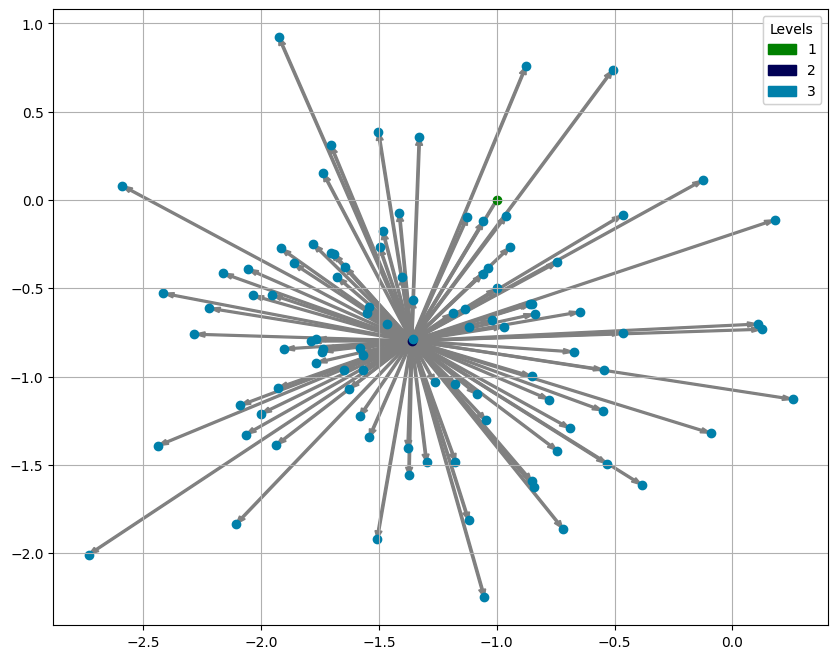

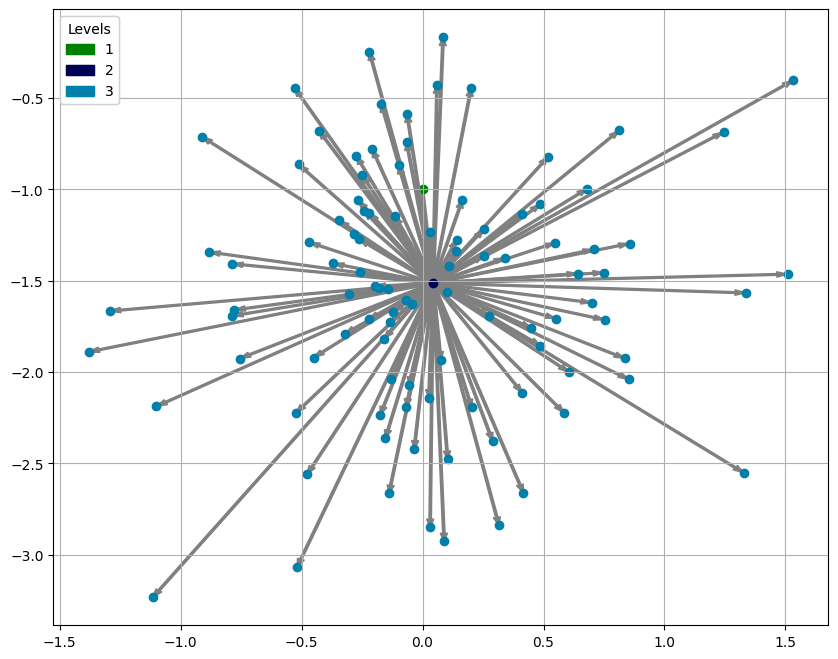

In [11]:
# plot
for i in range(n):
    dtree.plot_tree_2d(selector=lambda z: z['value'].reshape((-1,d))[i])

In [12]:
# time
%time down_unconditional.down(noise_tree,params.values())
%time updown.up(leaf_tree,params.values())
updown.up(utree,params.values())
%time updown.up(utree,params.values())

CPU times: total: 31.2 ms
Wall time: 29 ms
CPU times: total: 62.5 ms
Wall time: 65 ms
CPU times: total: 78.1 ms
Wall time: 86 ms


HypTree with 3 levels and 102 nodes

# MCMC

In [13]:
# Crank-Nicolson update function with possibly node-depdendent lambd
lambd = lambda node: .9
update_CN = lambda tree,key: update_noise_inplace(lambda node,new: node['noise']*lambd(node)+jnp.sqrt((1-lambd(node)**2))*new,tree,key)
# test
subkey, key = split(key)
update_CN(noise_tree,subkey)
%time update_CN(noise_tree,subkey)

CPU times: total: 0 ns
Wall time: 9 ms


HypTree with 3 levels and 102 nodes

In [15]:

# inference for Gaussian model, constant node covariance
def log_likelihood(state):
    """Log likelihood of the tree."""
    parameters,tree = state
    v,c,F,H = tree.root['value'],tree.root['c_0'],tree.root['F_0'],tree.root['H_0']
    return -c+F@v-.5*v.T@H@v

def log_posterior(state):
    """Log posterior given the state and data."""
    parameters,_ = state
    log_prior = parameters.log_prior()
    log_like = log_likelihood(state)
    return log_prior + log_like

def proposal(state, i, key):
    subkeys = jax.random.split(key,6)
    parameters,tree = state

    update_parameters = True
    if (update_parameters):
        new_parameters = parameters.propose(subkeys[0])
        # backwards filtering with updated parameters
        utree = updown.up(tree,new_parameters.values())

    # sample noise
    update_CN(utree,subkey)
    utree_CN = update_CN(utree,subkeys[5])

    # forwards filtering with updated noise
    dtree = updown.down(utree_CN,new_parameters.values())

    # update root
    # not implemented

    return new_parameters,dtree

# tree values and parameters
T = 1.
init_params = ParameterStore({
    'k_alpha': VarianceParameter(.5), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.5), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-2) # obersevation noise variance
    })
print("Initial parameters: ",init_params.values())
print("data parameters: ",params.values())

# initial state
leaf_tree.root['value'] = q
init_state = (init_params,updown.up(leaf_tree,init_params.values()))

# Run Metropolis-Hastings
samples = metropolis_hastings(log_posterior, proposal, init_state, 200, burn_in=000, rng_key=key, savef=lambda state: state[0])

# plot
trace_plots(samples)

Initial parameters:  {'k_alpha': 0.5, 'k_sigma': 0.5, 'obs_var': 0.01}
data parameters:  {'k_alpha': 0.5, 'k_sigma': 1.0, 'obs_var': 0.01}


  2%|▎         | 5/200 [00:12<08:16,  2.55s/it]